# Support Vector Machines

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
from sklearn.metrics import classification_report
from sklearn.preprocessing import scale

## Data

In [2]:
# We use the "Default" data set
df = pd.read_csv('data/Default.csv', index_col=0)

### Standardization

In [3]:
df.balance = scale(df.balance) #Good practice to standardize data for best SVM performance

In [4]:
df.income = scale(df.income)

In [5]:
df.student = df.student.map(dict(Yes=1, No=0))
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,2:], df.default, test_size=.2, random_state = 1)

## Single models

In [8]:
C = 1.0  # SVM regularization parameter

### SVM linear kernel

In [9]:
model = svm.SVC(kernel='linear', C=C).fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, zero_division =0))

              precision    recall  f1-score   support

          No       0.97      1.00      0.99      1941
         Yes       0.00      0.00      0.00        59

    accuracy                           0.97      2000
   macro avg       0.49      0.50      0.49      2000
weighted avg       0.94      0.97      0.96      2000



We can see that with this value of `C`, the classifier has a 0 recall rate. For the linear kernel, there is a more efficient implementation using `LinearSVC`:

In [52]:
model = svm.LinearSVC(C=C).fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, zero_division =0))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1941
           1       0.79      0.25      0.38        59

    accuracy                           0.98      2000
   macro avg       0.88      0.63      0.69      2000
weighted avg       0.97      0.98      0.97      2000



Without adjusting the cost parameter, we obtain better results using `LinearSVC`. See documentation at: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC

### Polynomial kernel

In [10]:
model = svm.SVC(kernel='poly', degree = 2, gamma = 'auto', C=C).fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.98      1.00      0.99      1941
         Yes       0.79      0.19      0.30        59

    accuracy                           0.97      2000
   macro avg       0.88      0.59      0.64      2000
weighted avg       0.97      0.97      0.97      2000



### Radial basis function kernel

In [11]:
model = svm.SVC(kernel='rbf', gamma=.1, C=C).fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.98      1.00      0.99      1941
         Yes       0.85      0.19      0.31        59

    accuracy                           0.97      2000
   macro avg       0.91      0.59      0.65      2000
weighted avg       0.97      0.97      0.97      2000



## Comparing decision boundaries

In [47]:
models = (svm.SVC(kernel='linear', C=C),
          svm.LinearSVC(C=C, max_iter=10000), # scales better for larger datasets than SVC with linear kernel but does the same thing
          svm.SVC(kernel='rbf', gamma=0.7, C=C),
          svm.SVC(kernel='poly', degree=3, gamma='auto', C=C))

For the purpose of plotting the decision boundaries, we will convert the target variable (`Default`) to numerical labels (0 and 1).

In [13]:
df.default = df.default.map(dict(Yes=1, No=0))
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,2:], df.default, test_size=.2, random_state = 1)

In [15]:
df.head()

,default,student,balance,income
1,0,0,-0.218835,0.813187
2,0,1,-0.037616,-1.605496
3,0,0,0.492410,-0.131212
4,0,0,-0.632893,0.164031
5,0,0,-0.102791,0.370915


In [49]:
## Helper functions 
#https://scikit-learn.org/stable/auto_examples/svm/plot_iris_svc.html#sphx-glr-auto-examples-svm-plot-iris-svc-py
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

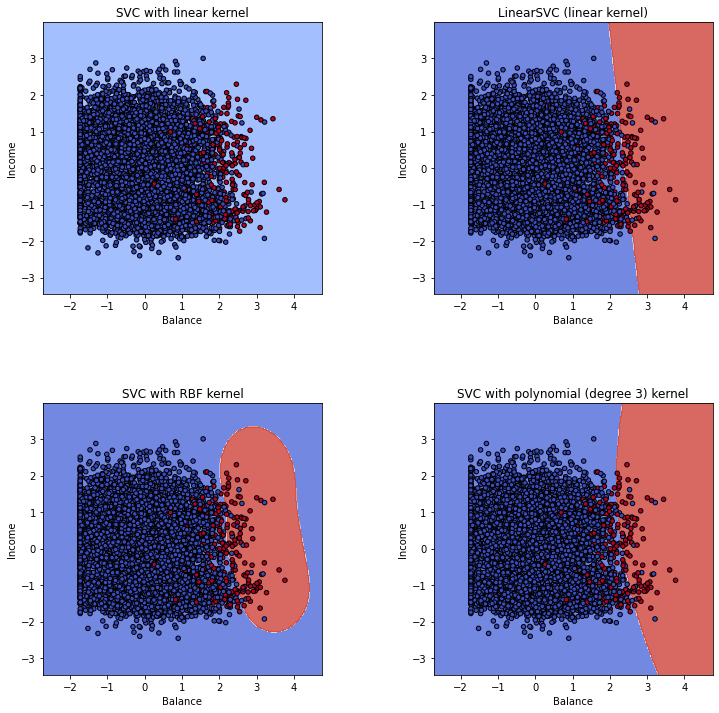

In [50]:
# Title for the plots
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel')

# Set-up 2x2 grid for plotting.
plt.rcParams["figure.figsize"] = (12,12)
fig, sub = plt.subplots(2, 2)#, sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
X0, X1 = X_train.iloc[:, 0], X_train.iloc[:, 1] #balance and income variables
xx, yy = make_meshgrid(X0, X1)

# Fit the models
fitted_svm_models = (clf.fit(X_train, y_train) for clf in models)
for clf, title, ax in zip(fitted_svm_models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy, cmap = plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c = y_train, cmap = plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Balance')
    ax.set_ylabel('Income')
    #ax.set_xticks(())
    #ax.set_yticks(())
    ax.set_title(title)

plt.show()